<a href="https://colab.research.google.com/github/Manna-Anirban/test/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from pylab import rcParams
from matplotlib.pyplot import figure
import gdown
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='darkgrid', palette='pastel', font_scale=1.3)

colors = ["blue", "orange", "green", "red", "purple", "grey"]

sns.set_palette(sns.color_palette(colors))

register_matplotlib_converters()

RANDOM_SEED = 50
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!gdown --id 1eYgzJoSR1V-lg3rh3CG8VXcQBuB6THt2

Downloading...
From: https://drive.google.com/uc?id=1eYgzJoSR1V-lg3rh3CG8VXcQBuB6THt2
To: /content/corona.csv
100% 768/768 [00:00<00:00, 357kB/s]


In [3]:
df = pd.read_csv('corona.csv') 
df.head()

,States,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
0,California,9191,10701,12026,13438,14336,15865,16957,18309,19472,20615,21794,22348,23338,24424,26182,27528,28963,30333,30978,33261,35396,37369,39254,41137,42164,43464,45031,46500,48917,50442,52197,53616,54937,56212,58815,60614
1,New York,83712,92381,102863,113704,122031,130689,138836,149316,159937,170512,180458,188694,195031,202208,213779,222284,229642,236732,242786,247512,251690,257216,263460,271590,282143,288045,291996,295106,299691,304372,308314,312977,316415,318953,321192,323978


In [4]:
df = df.iloc[:, 1:]
df.head()

,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
0,9191,10701,12026,13438,14336,15865,16957,18309,19472,20615,21794,22348,23338,24424,26182,27528,28963,30333,30978,33261,35396,37369,39254,41137,42164,43464,45031,46500,48917,50442,52197,53616,54937,56212,58815,60614
1,83712,92381,102863,113704,122031,130689,138836,149316,159937,170512,180458,188694,195031,202208,213779,222284,229642,236732,242786,247512,251690,257216,263460,271590,282143,288045,291996,295106,299691,304372,308314,312977,316415,318953,321192,323978


In [5]:
df.isnull().sum().sum()

0

In [6]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-04-01     92903
2020-04-02    103082
2020-04-03    114889
2020-04-04    127142
2020-04-05    136367
dtype: int64

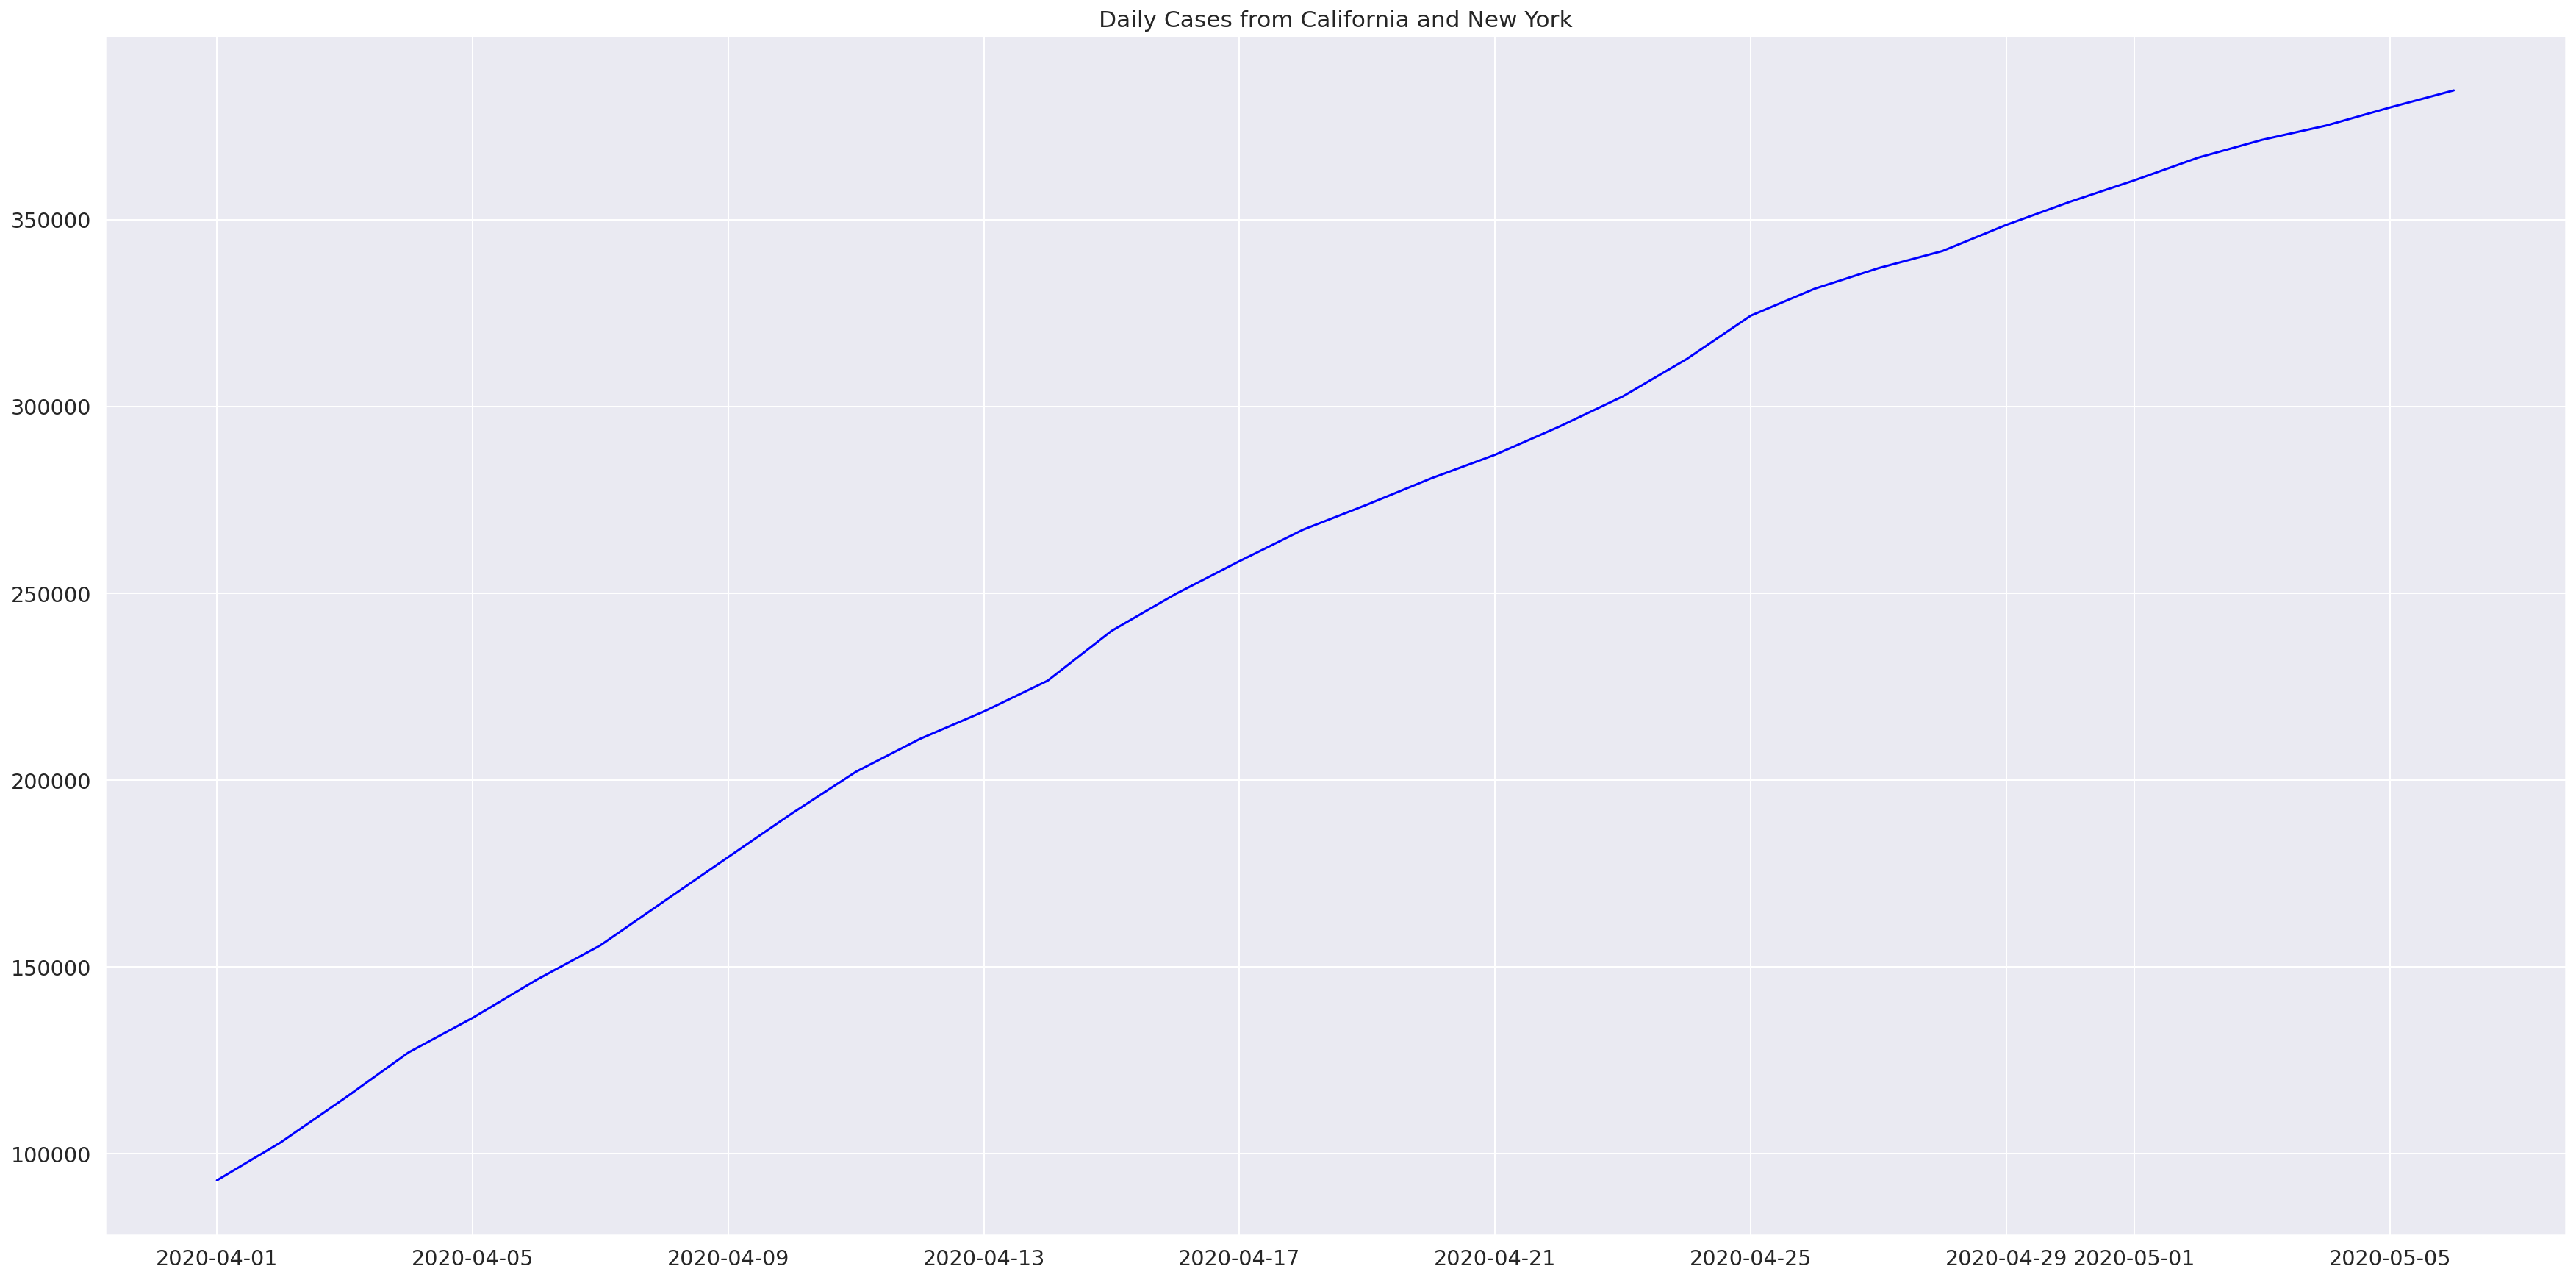

In [7]:
rcParams['figure.figsize'] = 30, 15
plt.plot(daily_cases)
plt.title("Daily Cases from California and New York");

In [8]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-04-01    92903
2020-04-02    10179
2020-04-03    11807
2020-04-04    12253
2020-04-05     9225
dtype: int64

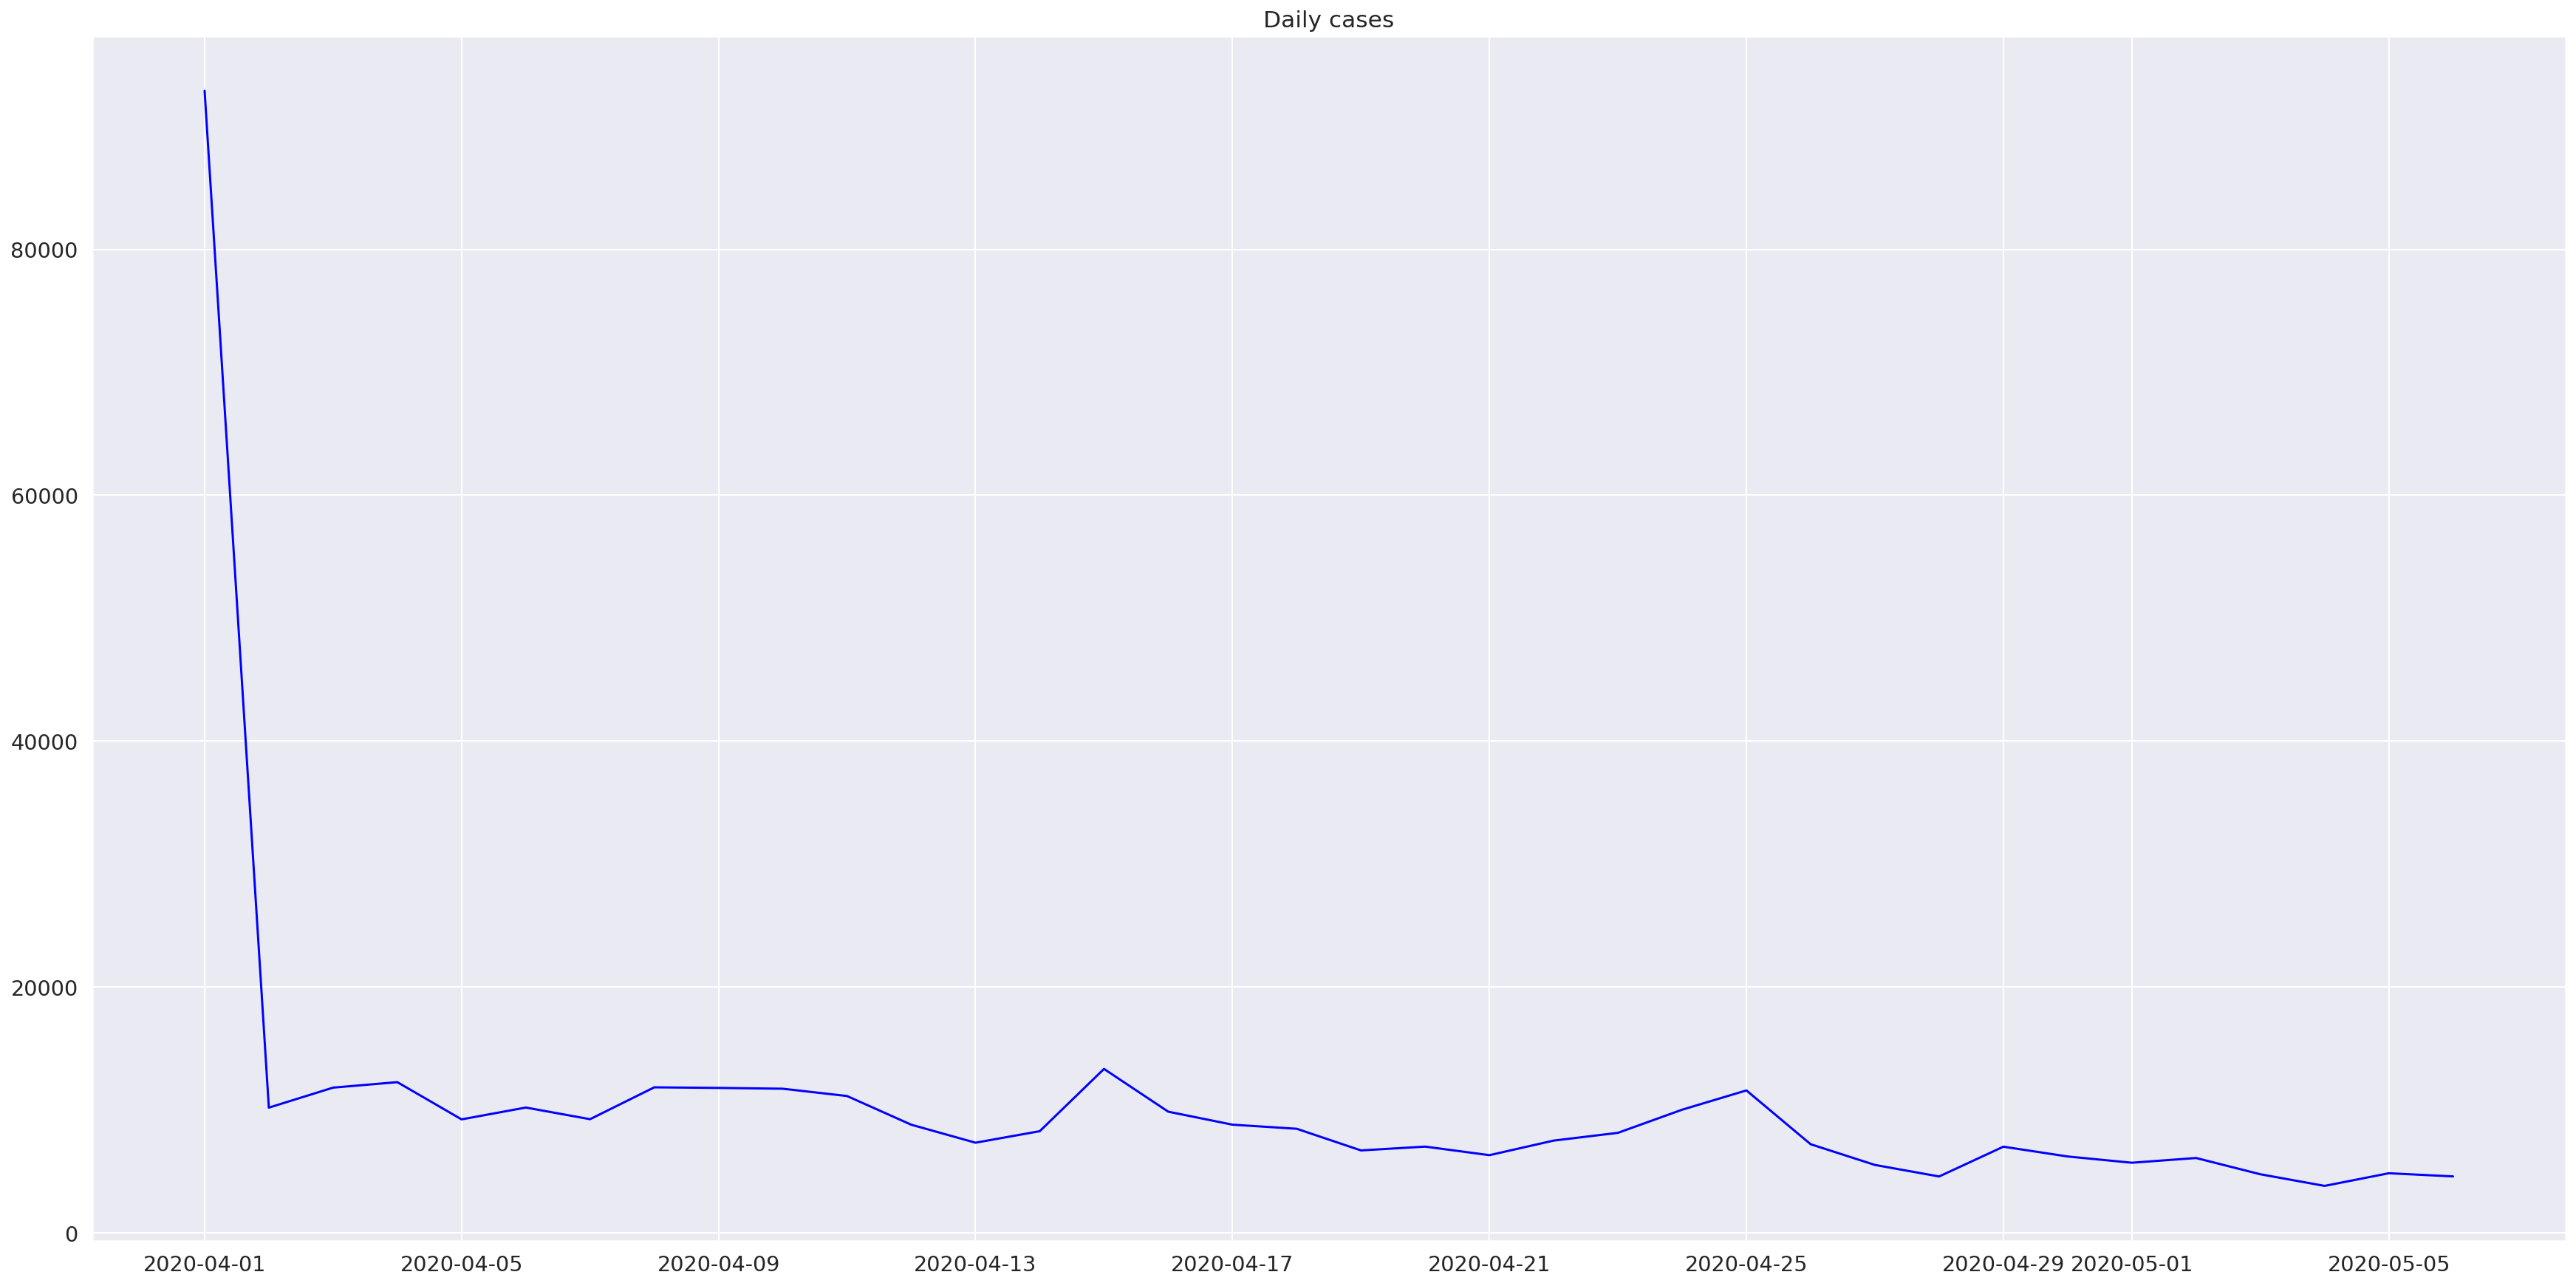

In [9]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [10]:
daily_cases.shape

(36,)

In [11]:
test_data_size = 10

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(26,)

In [0]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [13]:
X_train.shape

torch.Size([20, 5, 1])

In [14]:
X_train[:2]

tensor([[[1.0000],
         [0.0446],
         [0.0634],
         [0.0686],
         [0.0336]],

        [[0.0446],
         [0.0634],
         [0.0686],
         [0.0336],
         [0.0447]]])

In [15]:
y_train.shape

torch.Size([20, 1])

In [16]:
y_train[:2]

tensor([[0.0447],
        [0.0338]])

In [17]:
train_data[:10]

array([[1.        ],
       [0.04464719],
       [0.06344844],
       [0.06859915],
       [0.03362975],
       [0.04473958],
       [0.03379143],
       [0.06373715],
       [0.06318282],
       [0.0624206 ]])

In [0]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [0]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [20]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 0.052919819951057434 test loss: 0.0005156054394319654
Epoch 10 train loss: 0.015778031200170517 test loss: 0.019051823765039444
Epoch 20 train loss: 0.012381971813738346 test loss: 0.007279912009835243
Epoch 30 train loss: 0.010886671021580696 test loss: 0.01366107165813446
Epoch 40 train loss: 0.0105954734608531 test loss: 0.009783342480659485
Epoch 50 train loss: 0.010184502229094505 test loss: 0.01196584478020668


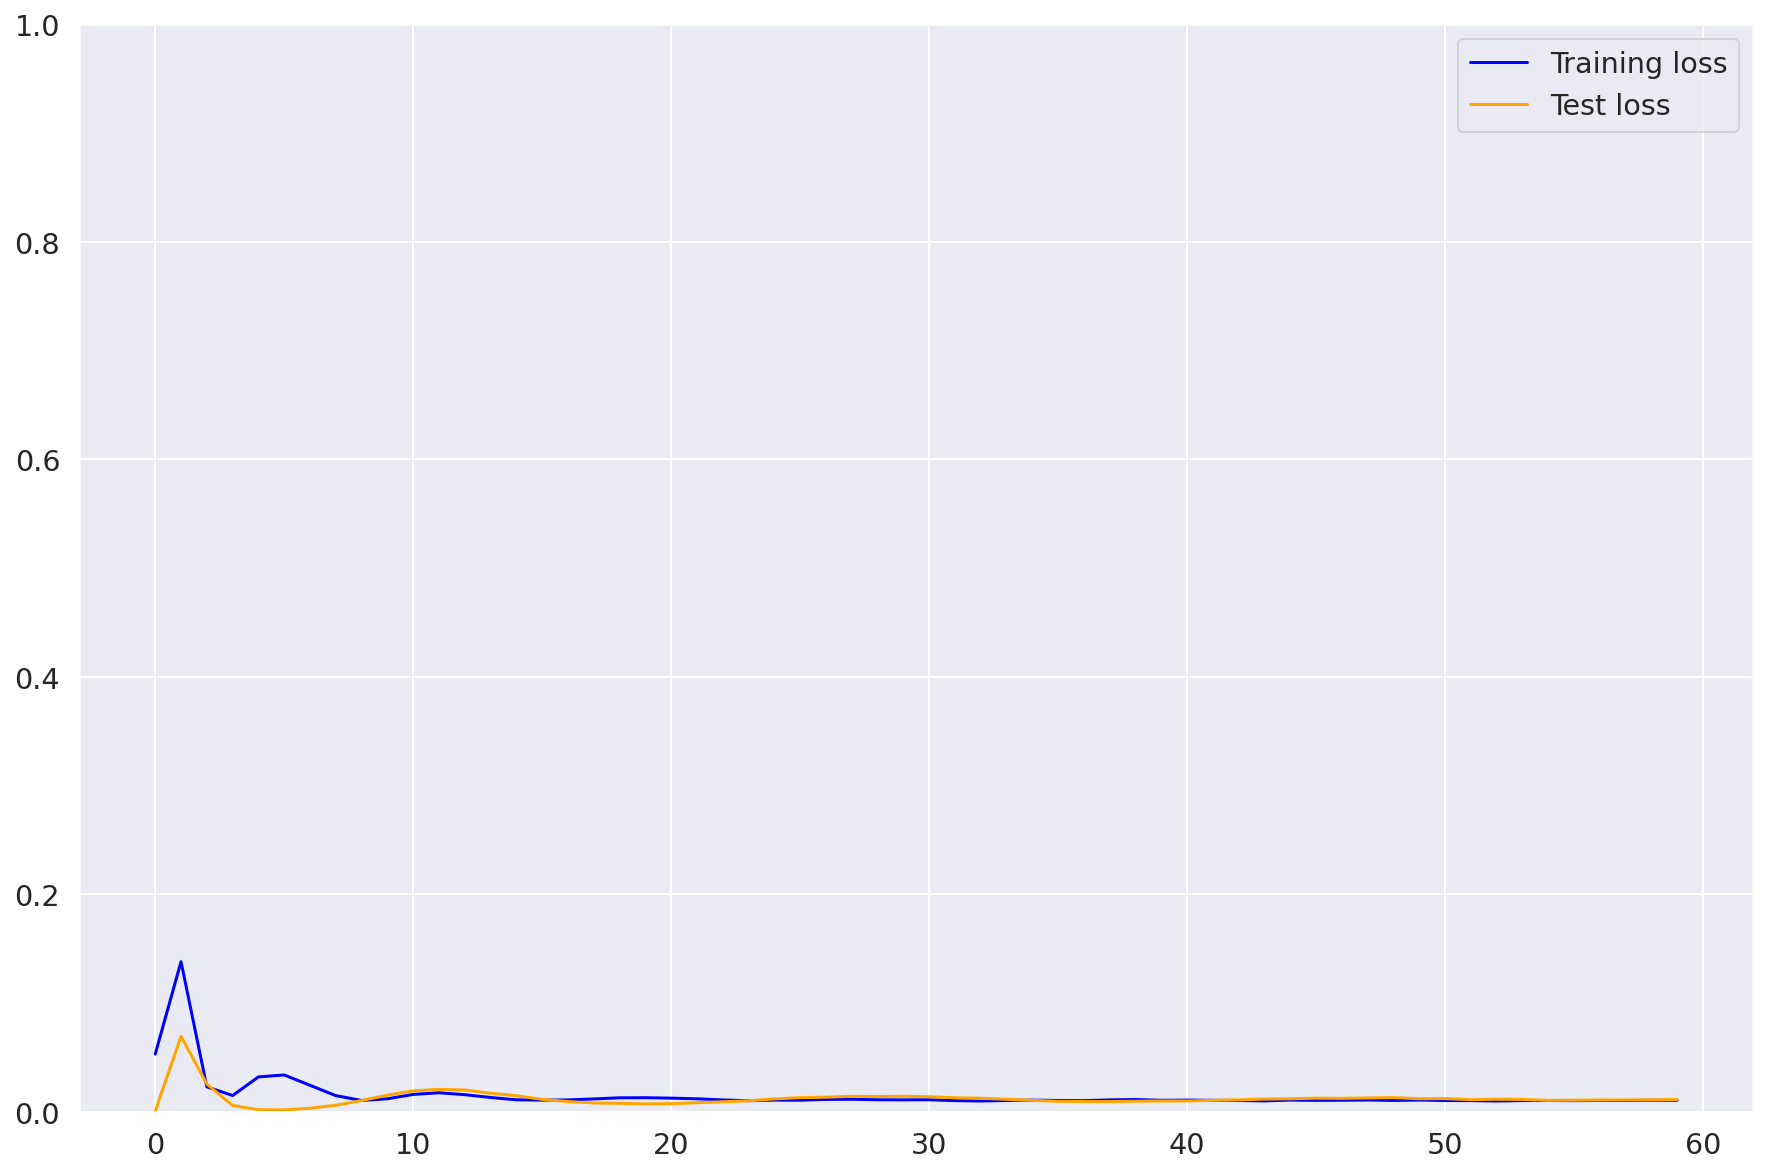

In [21]:
rcParams['figure.figsize'] = 15, 10
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 1))
plt.legend();

In [0]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

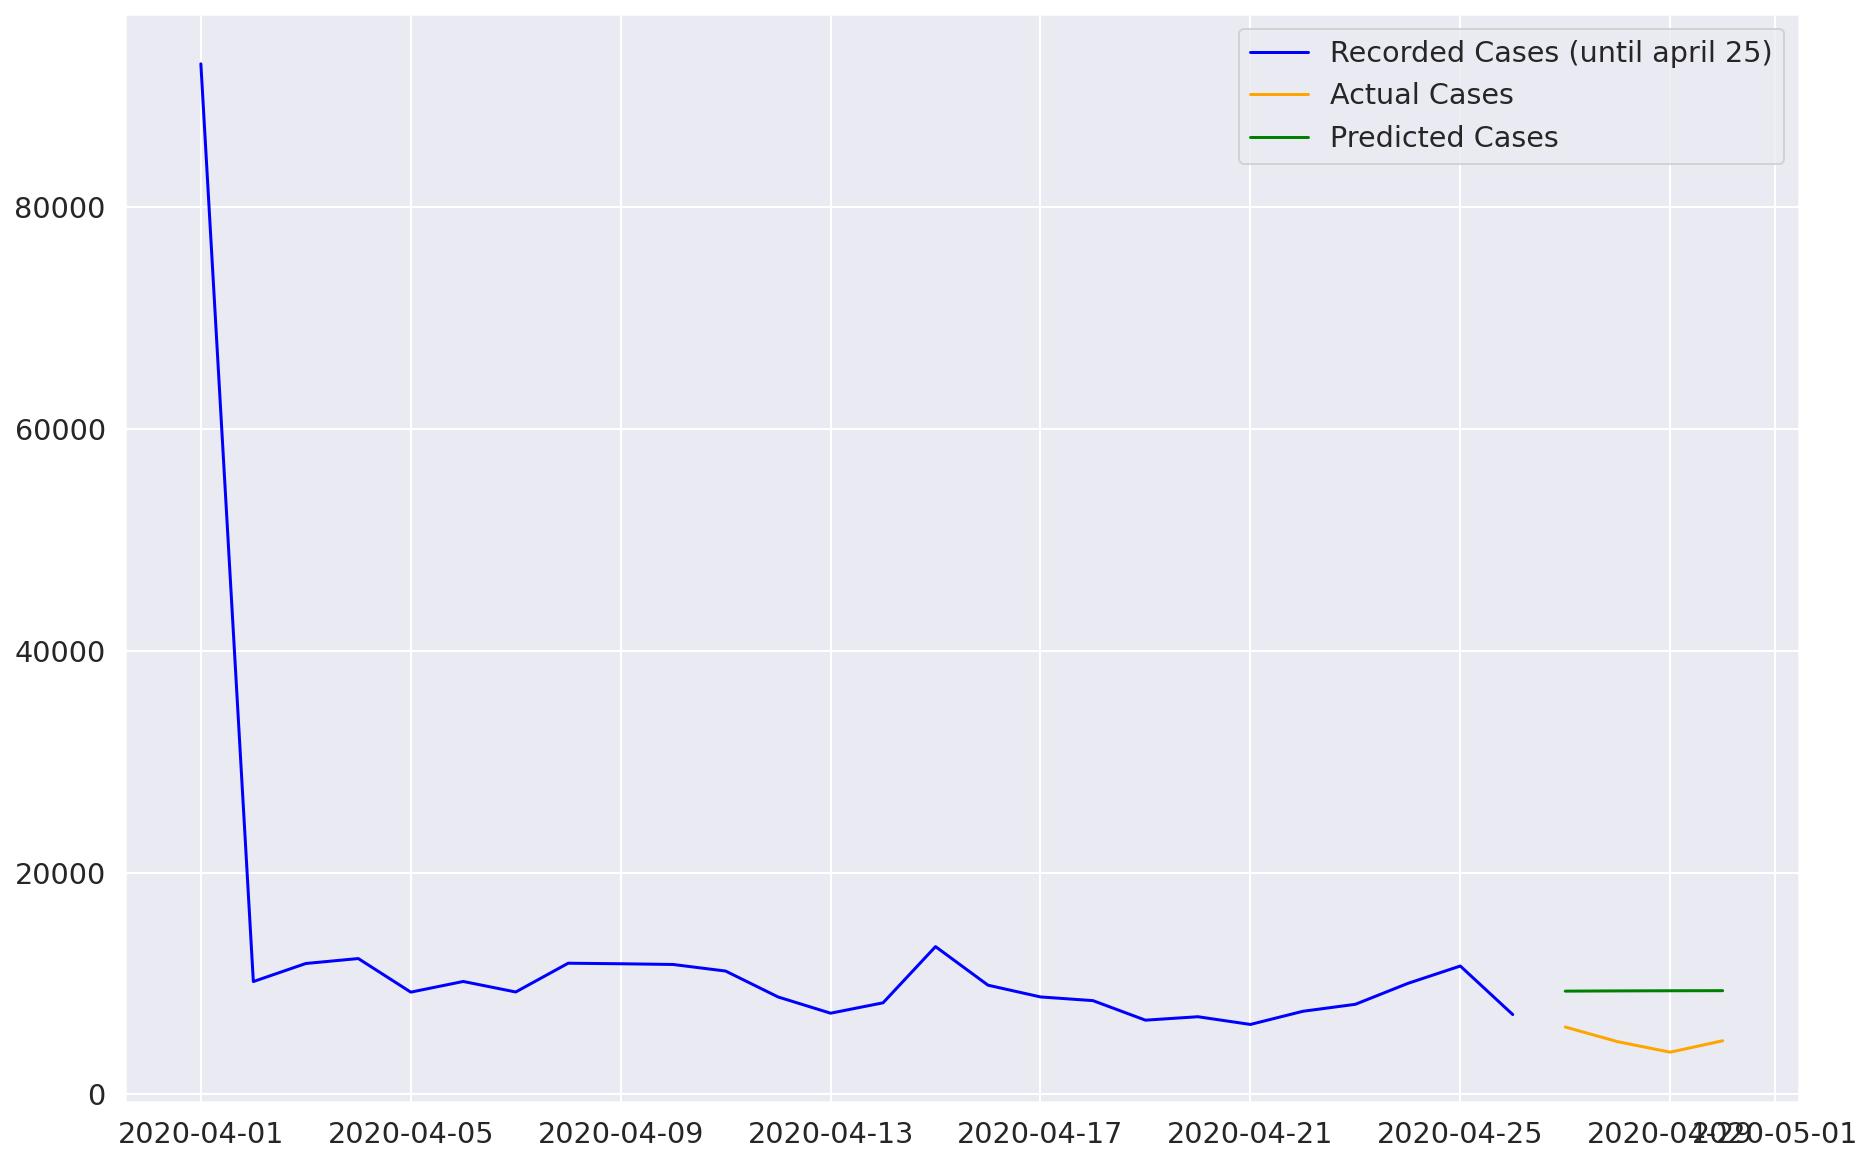

In [24]:
rcParams['figure.figsize'] = 15,10
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Recorded Cases (until april 25)'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Actual Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Cases'
)

plt.legend();

In [25]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(36, 1)

In [26]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 0.07477687299251556
Epoch 10 train loss: 0.014513037167489529
Epoch 20 train loss: 0.01259137038141489
Epoch 30 train loss: 0.011259126476943493
Epoch 40 train loss: 0.010375546291470528
Epoch 50 train loss: 0.010198562406003475


In [0]:
DAYS_TO_PREDICT = 14

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [29]:
daily_cases.index[-1]

Timestamp('2020-05-06 00:00:00')

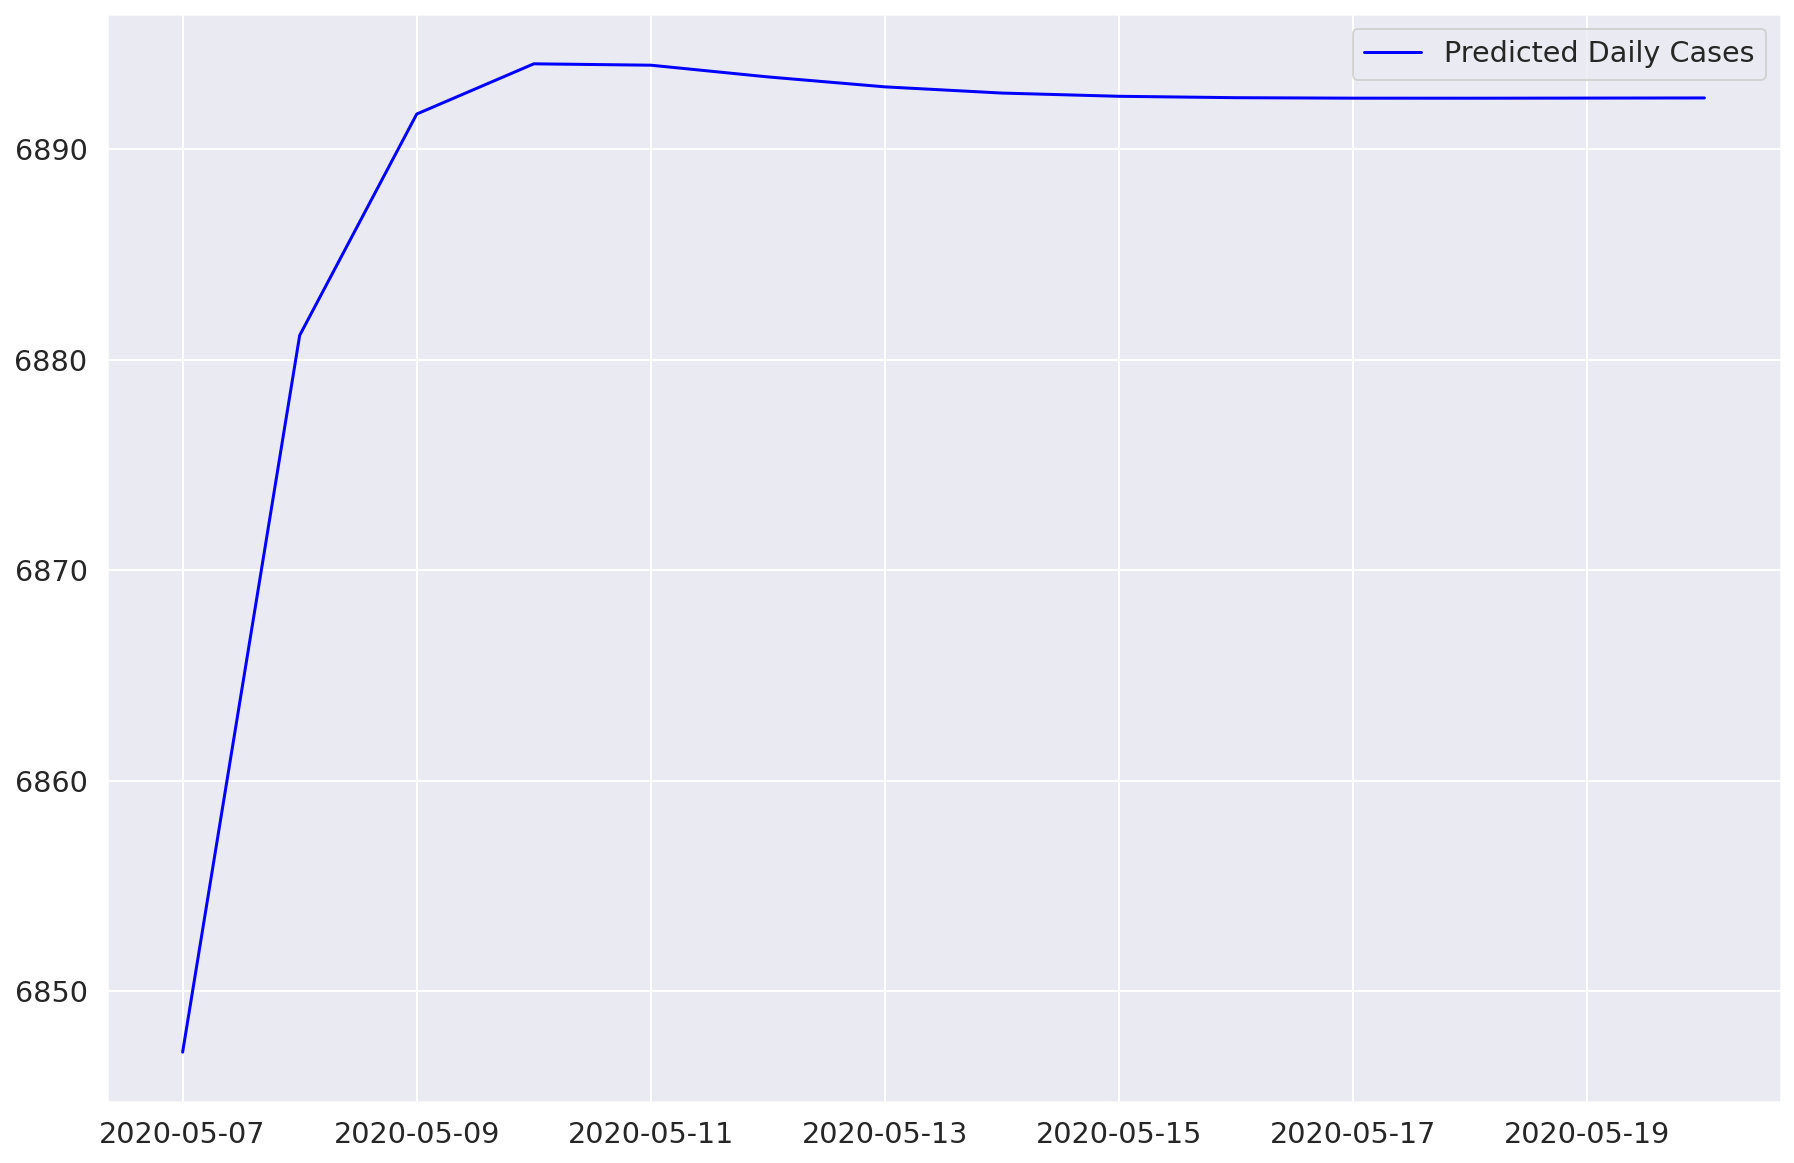

In [30]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

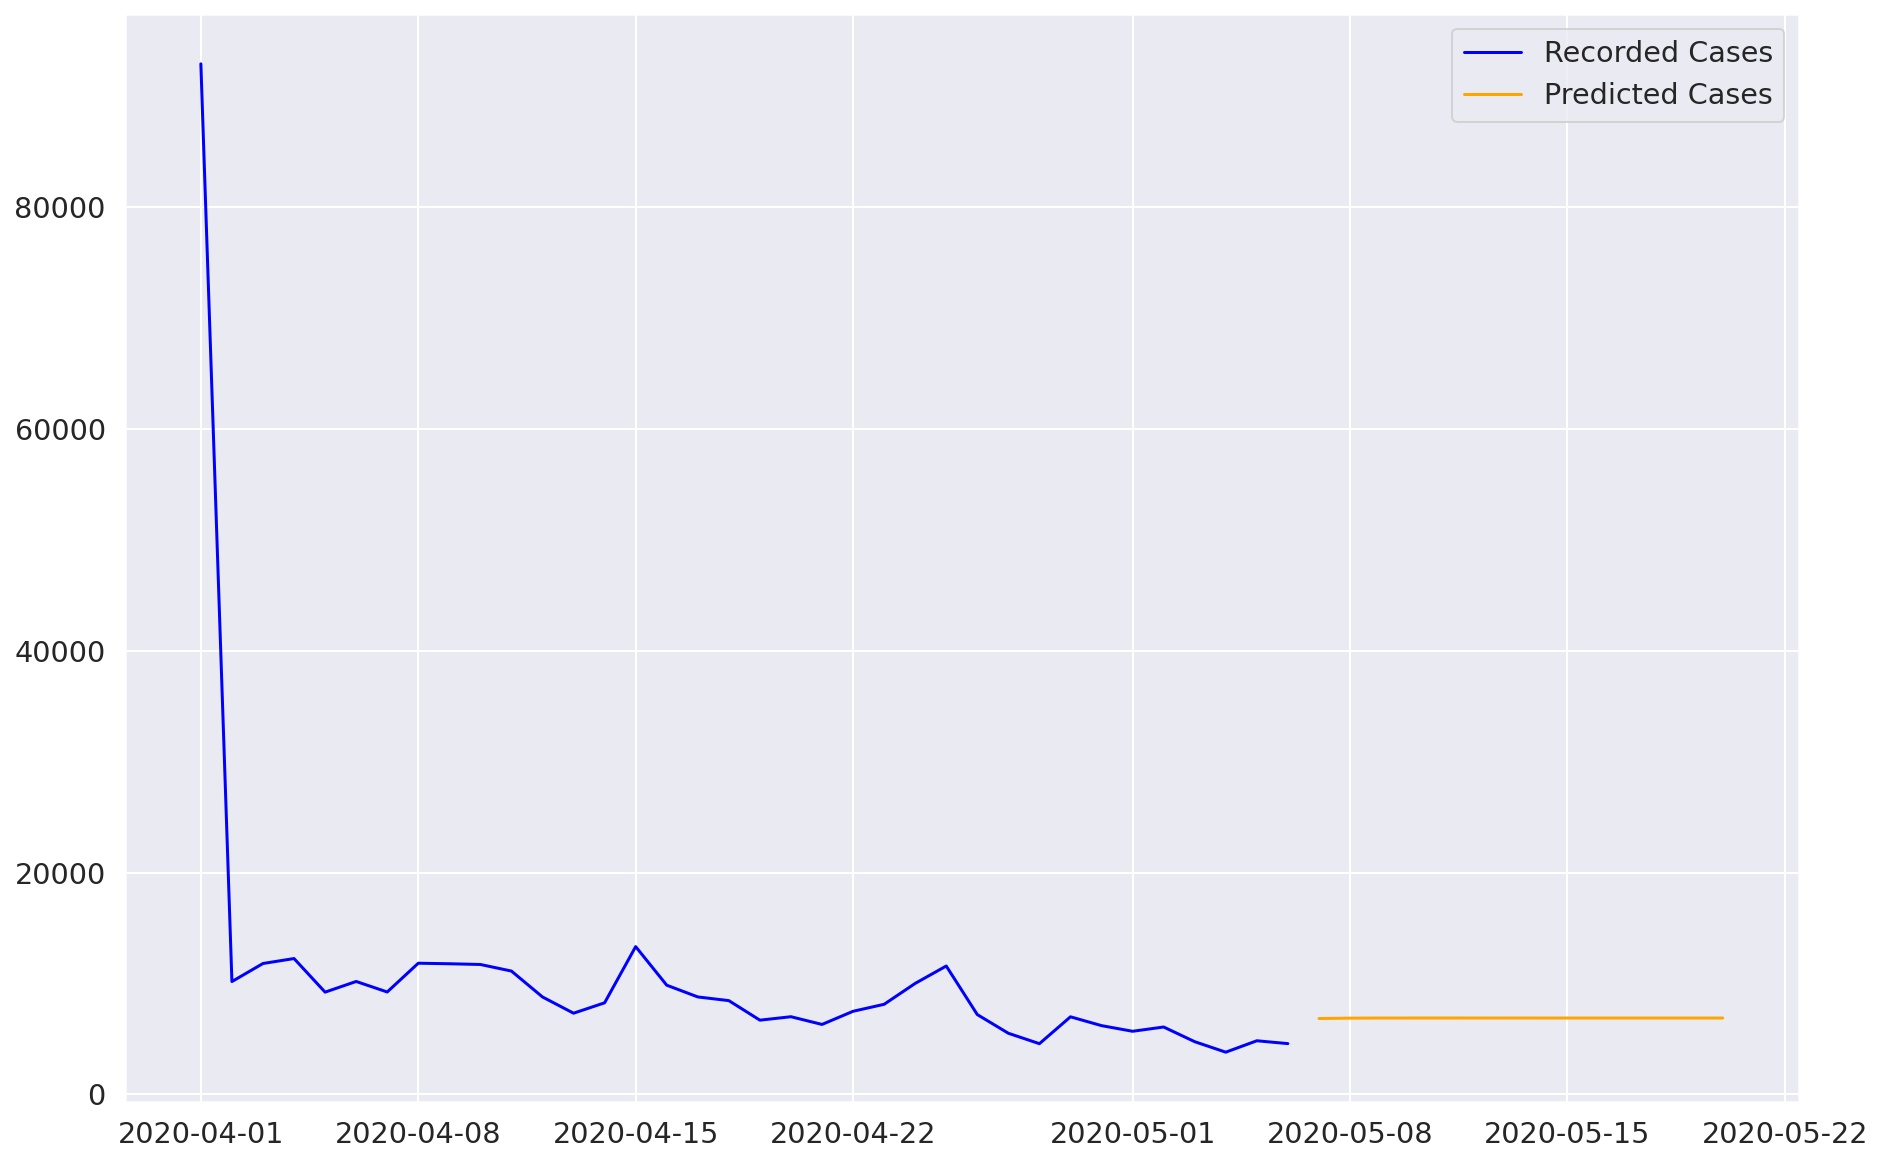

In [31]:
plt.plot(daily_cases, label='Recorded Cases')
plt.plot(predicted_cases, label='Predicted Cases')
plt.legend();